

#Import the Libraries




In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 22 kB/s 


In [ ]:
!nvidia-smi

Fri Dec 10 07:09:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import random
import zipfile
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Extract the train zip file

In [3]:
with zipfile.ZipFile("/content/drive/MyDrive/dogs-vs-cats.zip","r") as z:
    z.extractall(".")
    


In [4]:
with zipfile.ZipFile("/content/train.zip","r") as z:
    z.extractall(".")


#Create a Dataframe from train data

In [5]:
dirls = os.listdir("/content/train")
len(dirls)

25000

In [6]:
categories = []
for image in dirls :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [7]:
df = pd.DataFrame({'filename' : dirls, 'category' : categories})
df.head()

,filename,category
0,dog.9554.jpg,1
1,cat.11794.jpg,0
2,dog.9907.jpg,1
3,cat.6723.jpg,0
4,cat.9000.jpg,0


#Display some images from train data


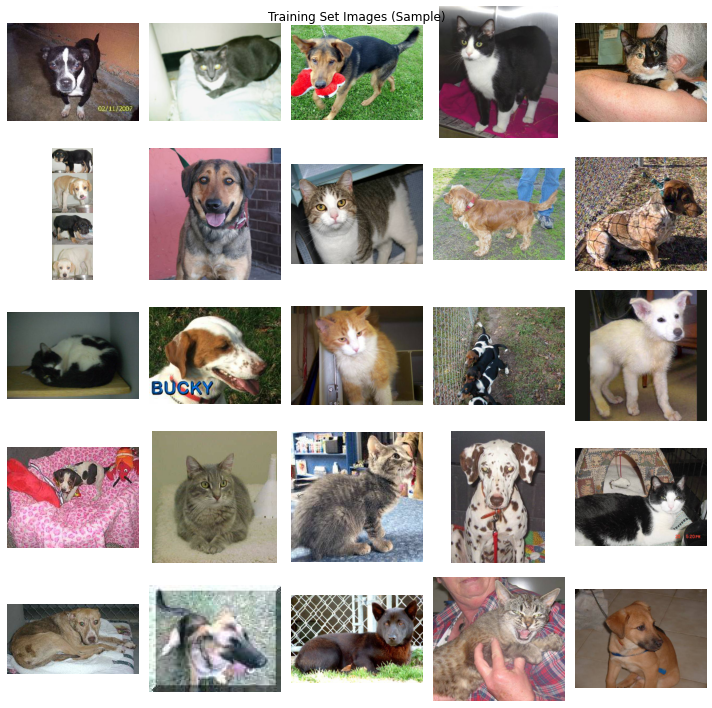

In [8]:
fig = plt.figure(figsize = (10,10))
fig.suptitle("Training Set Images (Sample)")

for i in range(25):

    plt.subplot(5, 5, i + 1)
    image = load_img("/content/train"+ "/" + df["filename"][i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

#Now build a CNN model

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

#Compile the model

###using optimiser ADAM
###change the learning rates
###Use early stopping


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            )
earlystop = EarlyStopping(patience=3)
model_check_point = ModelCheckpoint(filepath = 'model.h5',
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)

###Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

###So we will convert 1 to dog and 0 to cat

In [12]:
df['category'] = df['category'].map({0 : 'cat', 1 : 'dog'})

#DataPreparation


###create a validation set

In [13]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)


###Create Train Data image generator


In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16, 
    shuffle=True
)

Found 20000 validated image filenames belonging to 2 classes.


###create validation Image data generator


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train", 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 5000 validated image filenames belonging to 2 classes.


In [18]:
callbacks = [earlystop,learning_rate_reduction,model_check_point]

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

### Train the model


In [19]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.5791
Epoch 00001: val_accuracy improved from -inf to 0.65375, saving model to model.h5
1000/1000 [==============================] - 281s 271ms/step - loss: 0.6784 - accuracy: 0.5791 - val_loss: 0.6390 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6739
Epoch 00002: val_accuracy improved from 0.65375 to 0.70875, saving model to model.h5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.6022 - accuracy: 0.6739 - val_loss: 0.5845 - val_accuracy: 0.7088 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.7271
Epoch 00003: val_accuracy improved from 0.70875 to 0.73600, saving model to model.h5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.5428 - accuracy: 0.7271 - val_loss: 0.5434 - val_accuracy: 0.7360 - lr: 0.0010
Epoc

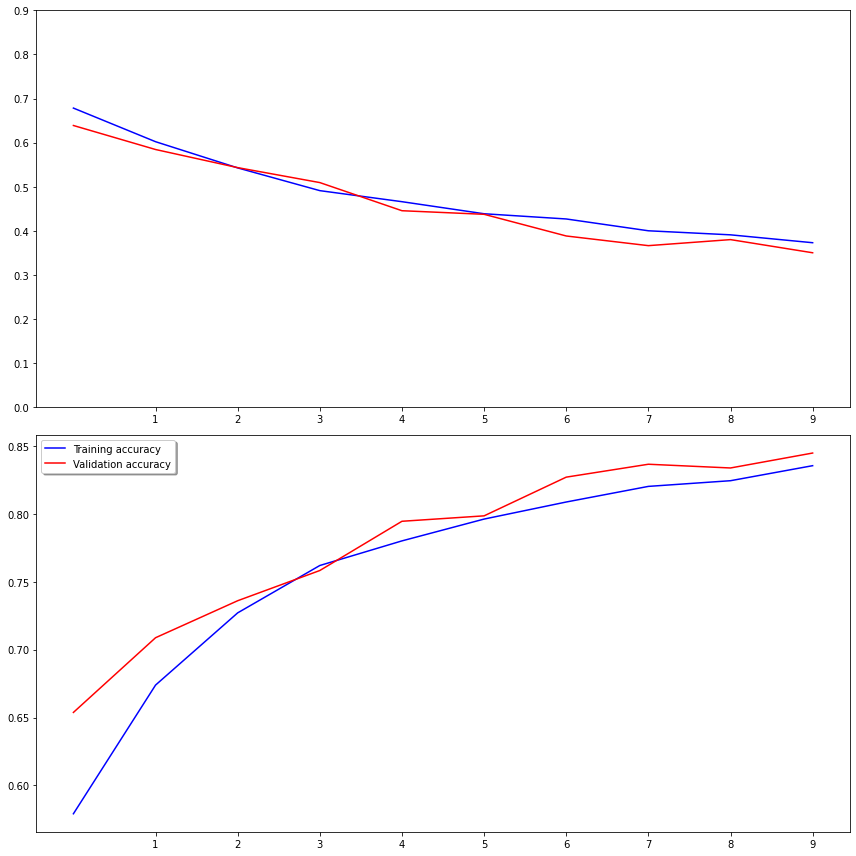

In [20]:
epochs = 10
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [21]:
predict = model.predict(validation_generator)

In [22]:
len(predict)

5000

In [23]:
validate_df['predictions'] = np.argmax(predict, axis=-1)

In [24]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions'] = validate_df['predictions'].replace(label_map)

In [25]:
validate_df['predictions'] = validate_df['predictions'].replace({ 'dog': 1, 'cat': 0 })

In [26]:
validate_df['category'] = validate_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [27]:
validate_df.head()

,filename,category,predictions
6868,dog.5025.jpg,1,0
24016,cat.165.jpg,0,0
9668,cat.9108.jpg,0,1
13640,dog.9707.jpg,1,1
14018,dog.2359.jpg,1,0


In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report 
print(classification_report(validate_df['category'], validate_df['predictions']))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2483
           1       0.87      0.81      0.84      2517

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [29]:
model.evaluate(validation_generator)

313/313 [==============================] - 20s 65ms/step - loss: 0.3517 - accuracy: 0.8452


[0.35168924927711487, 0.8452000021934509]

# Model1: Use dropout after conv & Fully connected layers without Batch normalization

In [30]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model1.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model1.add(Dense(2, activation='softmax'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [31]:
callbacks = [earlystop,learning_rate_reduction]

In [32]:
history1 = model1.fit(
    train_generator, 
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/5
1000/1000 [==============================] - 269s 268ms/step - loss: 0.6885 - accuracy: 0.5490 - val_loss: 0.6367 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 2/5
1000/1000 [==============================] - 267s 267ms/step - loss: 0.6227 - accuracy: 0.6542 - val_loss: 0.5731 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 3/5
1000/1000 [==============================] - 263s 263ms/step - loss: 0.5683 - accuracy: 0.7013 - val_loss: 0.5346 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 4/5
1000/1000 [==============================] - 267s 267ms/step - loss: 0.5231 - accuracy: 0.7394 - val_loss: 0.5286 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 5/5
1000/1000 [==============================] - 267s 267ms/step - loss: 0.4999 - accuracy: 0.7538 - val_loss: 0.4558 - val_accuracy: 0.7935 - lr: 0.0010


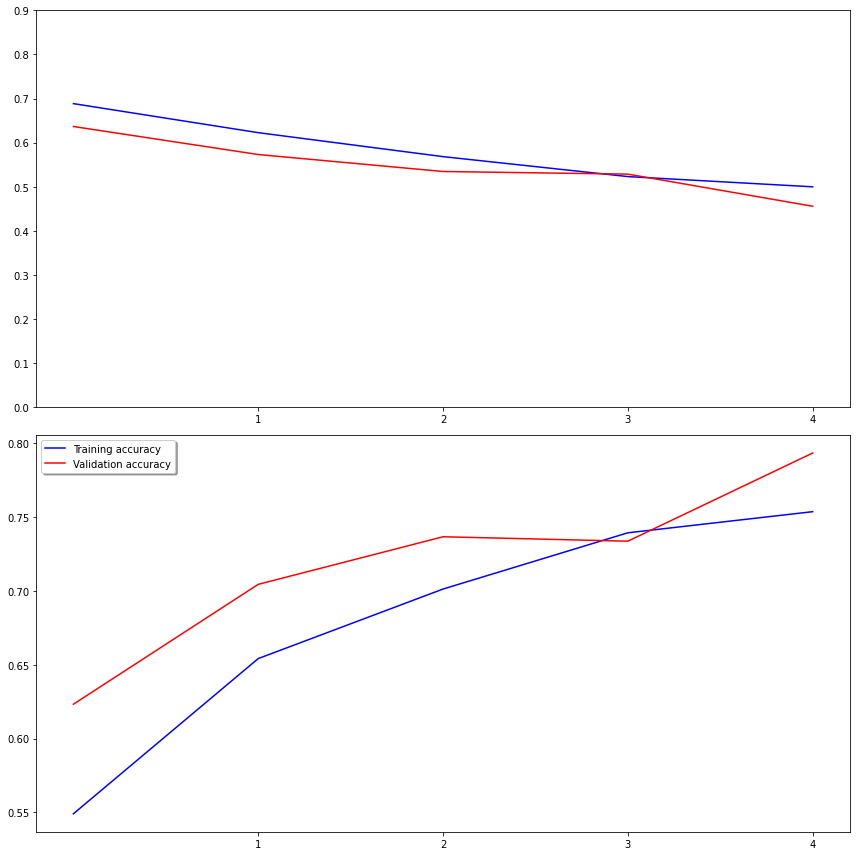

In [33]:
epochs = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history1.history['loss'], color='b', label="Training loss")
ax1.plot(history1.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [34]:
predict = model1.predict(validation_generator)
validate_df['predictions_m1'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions_m1'] = validate_df['predictions_m1'].replace(label_map)
validate_df['predictions_m1'] = validate_df['predictions_m1'].replace({ 'dog': 1, 'cat': 0 })
print(classification_report(validate_df['category'], validate_df['predictions_m1']))
print(confusion_matrix(validate_df['category'], validate_df['predictions_m1']))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2483
           1       0.83      0.75      0.78      2517

    accuracy                           0.79      5000
   macro avg       0.80      0.79      0.79      5000
weighted avg       0.80      0.79      0.79      5000

[[2086  397]
 [ 637 1880]]


In [35]:
model1.evaluate(validation_generator)[0]

313/313 [==============================] - 21s 66ms/step - loss: 0.4550 - accuracy: 0.7932


0.4549732506275177

# Model2: Remove drop out, use Batch normalization

In [36]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))



model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [37]:
history2 = model2.fit(
    train_generator, 
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/5
1000/1000 [==============================] - 274s 273ms/step - loss: 0.6402 - accuracy: 0.6719 - val_loss: 0.6127 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 2/5
1000/1000 [==============================] - 277s 277ms/step - loss: 0.5183 - accuracy: 0.7479 - val_loss: 0.6438 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 3/5
1000/1000 [==============================] - 274s 274ms/step - loss: 0.4750 - accuracy: 0.7723 - val_loss: 0.5536 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 4/5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.4382 - accuracy: 0.7989 - val_loss: 0.5208 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 5/5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.4191 - accuracy: 0.8070 - val_loss: 0.7236 - val_accuracy: 0.6740 - lr: 0.0010


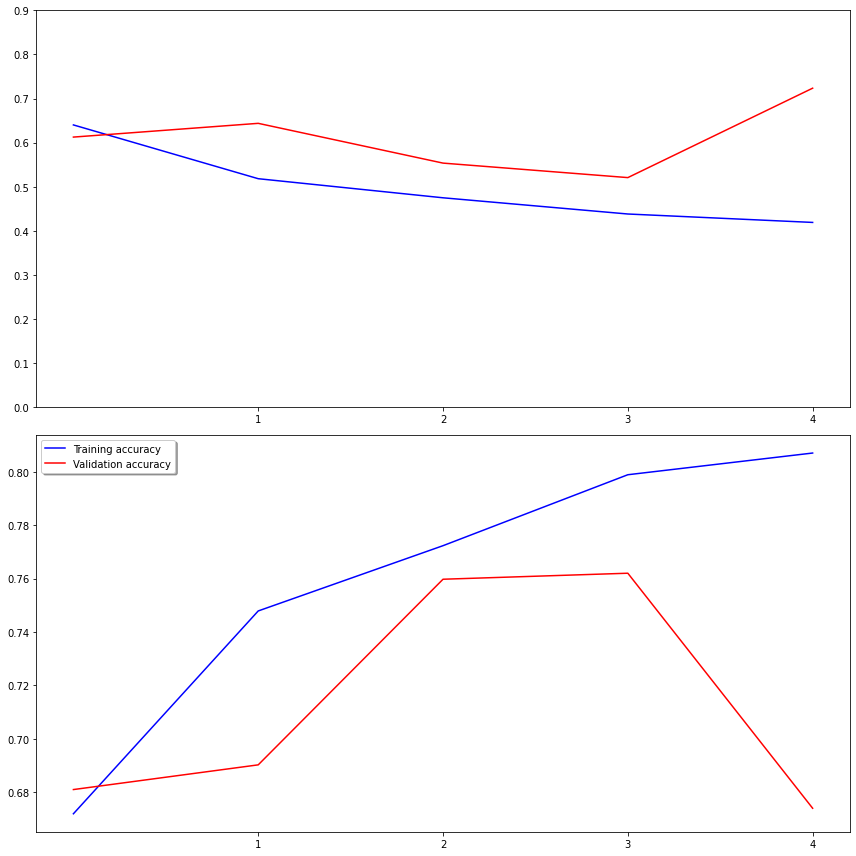

In [38]:
epochs = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history2.history['loss'], color='b', label="Training loss")
ax1.plot(history2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [39]:
predict = model2.predict(validation_generator)
validate_df['predictions_m2'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions_m2'] = validate_df['predictions_m2'].replace(label_map)
validate_df['predictions_m2'] = validate_df['predictions_m2'].replace({ 'dog': 1, 'cat': 0 })
print(classification_report(validate_df['category'], validate_df['predictions_m2']))
print(confusion_matrix(validate_df['category'], validate_df['predictions_m2']))

              precision    recall  f1-score   support

           0       0.92      0.36      0.52      2483
           1       0.61      0.97      0.75      2517

    accuracy                           0.67      5000
   macro avg       0.77      0.67      0.63      5000
weighted avg       0.76      0.67      0.63      5000

[[ 896 1587]
 [  73 2444]]


In [40]:
model2.evaluate(validation_generator)

313/313 [==============================] - 21s 69ms/step - loss: 0.7407 - accuracy: 0.6680


[0.7407144904136658, 0.6679999828338623]

# Model3: Remove dropout & use L2 regularization

In [47]:


model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))



model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(2, activation='softmax'))
model3.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model3.add(Dense(2, activation='softmax'))

In [48]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                      

In [49]:
history3 = model3.fit(
    train_generator, 
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/5
1000/1000 [==============================] - 274s 272ms/step - loss: 0.7159 - accuracy: 0.5477 - val_loss: 0.6934 - val_accuracy: 0.5575 - lr: 0.0010
Epoch 2/5
1000/1000 [==============================] - 272s 272ms/step - loss: 0.6889 - accuracy: 0.5836 - val_loss: 0.6866 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 3/5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.6758 - accuracy: 0.6129 - val_loss: 0.6849 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 4/5
1000/1000 [==============================] - 278s 278ms/step - loss: 0.6533 - accuracy: 0.6523 - val_loss: 0.6368 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 5/5
1000/1000 [==============================] - 272s 272ms/step - loss: 0.6574 - accuracy: 0.6431 - val_loss: 0.6513 - val_accuracy: 0.6520 - lr: 0.0010


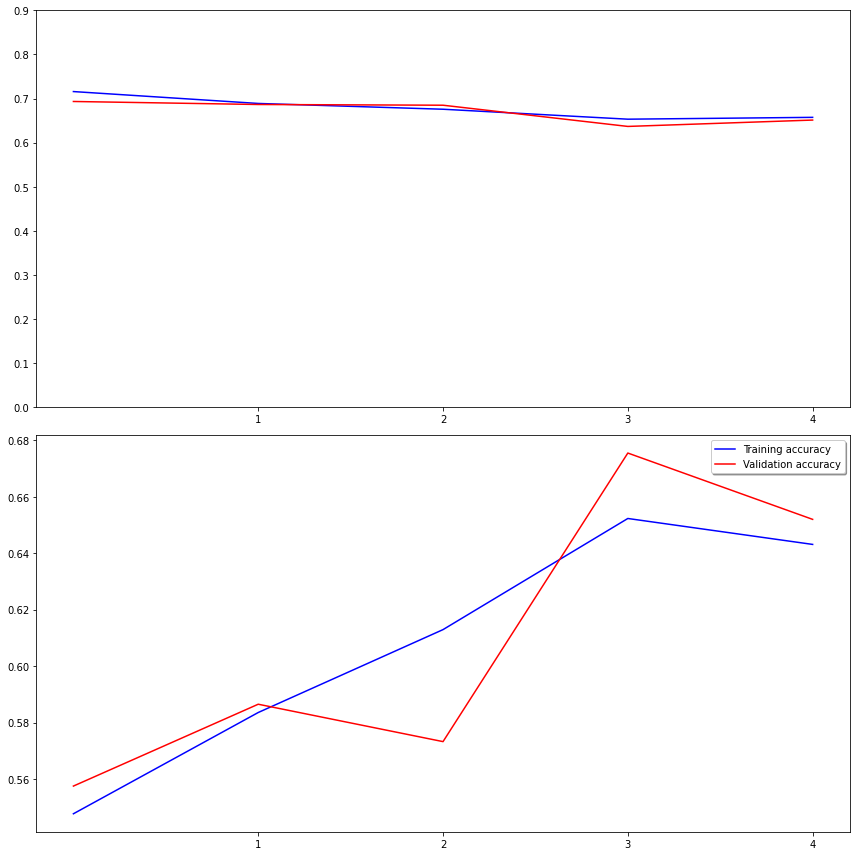

In [50]:
epochs = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history3.history['loss'], color='b', label="Training loss")
ax1.plot(history3.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history3.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history3.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [51]:
predict = model3.predict(validation_generator)
validate_df['predictions_m3'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions_m3'] = validate_df['predictions_m3'].replace(label_map)
validate_df['predictions_m3'] = validate_df['predictions_m3'].replace({ 'dog': 1, 'cat': 0 })
print(classification_report(validate_df['category'], validate_df['predictions_m3']))
print(confusion_matrix(validate_df['category'], validate_df['predictions_m3']))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68      2483
           1       0.70      0.56      0.62      2517

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.65      5000
weighted avg       0.66      0.66      0.65      5000

[[1865  618]
 [1101 1416]]


In [52]:
model3.evaluate(validation_generator)

313/313 [==============================] - 21s 67ms/step - loss: 0.6500 - accuracy: 0.6562


[0.6500179767608643, 0.6561999917030334]

# Model4: Use dropout after convolution layer, L2 in Fully connected layer,Batch normalization after conv-Layer

In [53]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

model4.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model4.add(BatchNormalization())
model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))



model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(2, activation='softmax'))
model4.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model4.add(Dense(2, activation='softmax'))

In [55]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_24 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_25 (Bat  (None, 109, 109, 64)    

In [56]:
history4 = model4.fit(
    train_generator, 
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/5
1000/1000 [==============================] - 277s 276ms/step - loss: 0.7159 - accuracy: 0.5489 - val_loss: 0.6947 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 2/5
1000/1000 [==============================] - 275s 275ms/step - loss: 0.6906 - accuracy: 0.5746 - val_loss: 0.6863 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 3/5
1000/1000 [==============================] - 275s 275ms/step - loss: 0.6846 - accuracy: 0.5885 - val_loss: 0.6784 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 4/5
1000/1000 [==============================] - 274s 274ms/step - loss: 0.6798 - accuracy: 0.5993 - val_loss: 0.7082 - val_accuracy: 0.5497 - lr: 0.0010
Epoch 5/5
1000/1000 [==============================] - 273s 273ms/step - loss: 0.6678 - accuracy: 0.6293 - val_loss: 0.6628 - val_accuracy: 0.6380 - lr: 0.0010


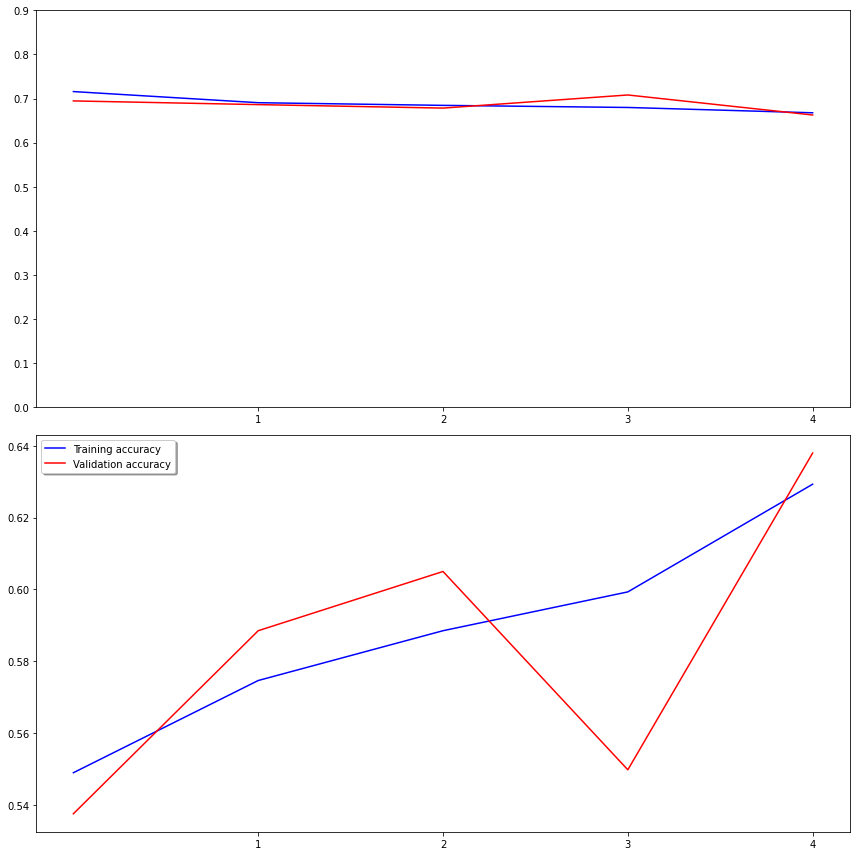

In [57]:
epochs = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history4.history['loss'], color='b', label="Training loss")
ax1.plot(history4.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history4.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history4.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [58]:
predict = model4.predict(validation_generator)
validate_df['predictions_m4'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions_m4'] = validate_df['predictions_m4'].replace(label_map)
validate_df['predictions_m4'] = validate_df['predictions_m4'].replace({ 'dog': 1, 'cat': 0 })
print(classification_report(validate_df['category'], validate_df['predictions_m4']))
print(confusion_matrix(validate_df['category'], validate_df['predictions_m4']))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      2483
           1       0.65      0.62      0.63      2517

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000

[[1621  862]
 [ 947 1570]]


In [59]:
model4.evaluate(validation_generator)

313/313 [==============================] - 21s 67ms/step - loss: 0.6632 - accuracy: 0.6382


[0.6632082462310791, 0.6381999850273132]

#Model5: Add a new conv layer

In [61]:
model5 = Sequential()

model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(BatchNormalization())
model5.add(MaxPool2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(BatchNormalization())
model5.add(MaxPool2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model5.add(BatchNormalization())
model5.add(MaxPool2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))



model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(2, activation='softmax'))
model5.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01)))
model5.add(Dense(2, activation='softmax'))

In [62]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_32 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_33 (Bat  (None, 109, 109, 64)   

In [63]:
history5 = model5.fit(
    train_generator, 
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
    
    )

Epoch 1/5
1000/1000 [==============================] - 276s 275ms/step - loss: 0.7138 - accuracy: 0.5228 - val_loss: 0.6934 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 2/5
1000/1000 [==============================] - 274s 274ms/step - loss: 0.6887 - accuracy: 0.5845 - val_loss: 0.6941 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.6017
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1000/1000 [==============================] - 274s 273ms/step - loss: 0.6806 - accuracy: 0.6017 - val_loss: 0.7024 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 4/5
1000/1000 [==============================] - 276s 276ms/step - loss: 0.6709 - accuracy: 0.6219 - val_loss: 0.6575 - val_accuracy: 0.6528 - lr: 1.0000e-04
Epoch 5/5
1000/1000 [==============================] - 275s 275ms/step - loss: 0.6578 - accuracy: 0.6507 - val_loss: 0.6573 - val_accuracy: 0.6520 - lr: 1.0000e-04


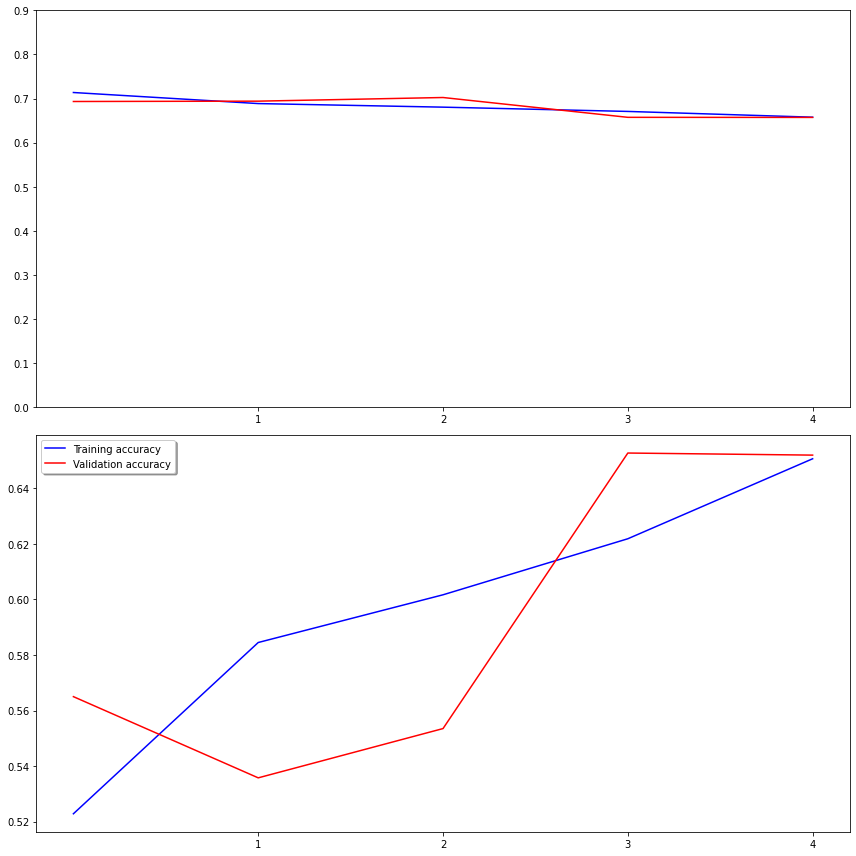

In [64]:
epochs = 6
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history5.history['loss'], color='b', label="Training loss")
ax1.plot(history5.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history5.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history5.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [65]:
predict = model5.predict(validation_generator)
validate_df['predictions_m5'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predictions_m5'] = validate_df['predictions_m5'].replace(label_map)
validate_df['predictions_m5'] = validate_df['predictions_m5'].replace({ 'dog': 1, 'cat': 0 })
print(classification_report(validate_df['category'], validate_df['predictions_m5']))
print(confusion_matrix(validate_df['category'], validate_df['predictions_m5']))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66      2483
           1       0.66      0.62      0.64      2517

    accuracy                           0.65      5000
   macro avg       0.65      0.65      0.65      5000
weighted avg       0.65      0.65      0.65      5000

[[1692  791]
 [ 949 1568]]


In [66]:
model5.evaluate(validation_generator)

313/313 [==============================] - 21s 67ms/step - loss: 0.6581 - accuracy: 0.6520


[0.6581048369407654, 0.6520000100135803]

###Extract the test zip file

In [67]:
with zipfile.ZipFile("/content/test1.zip","r") as z:
    z.extractall(".")


###Prepare Test data

In [69]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})


###Create Test Data image generator

In [71]:
nb_samples = test_df.shape[0]
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224,224) ,
    batch_size=16,
    shuffle=False
)

Found 12500 validated image filenames.


In [75]:
predict = model.predict(test_generator)


In [76]:
len(predict)

12500

In [77]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

###See predictions with images

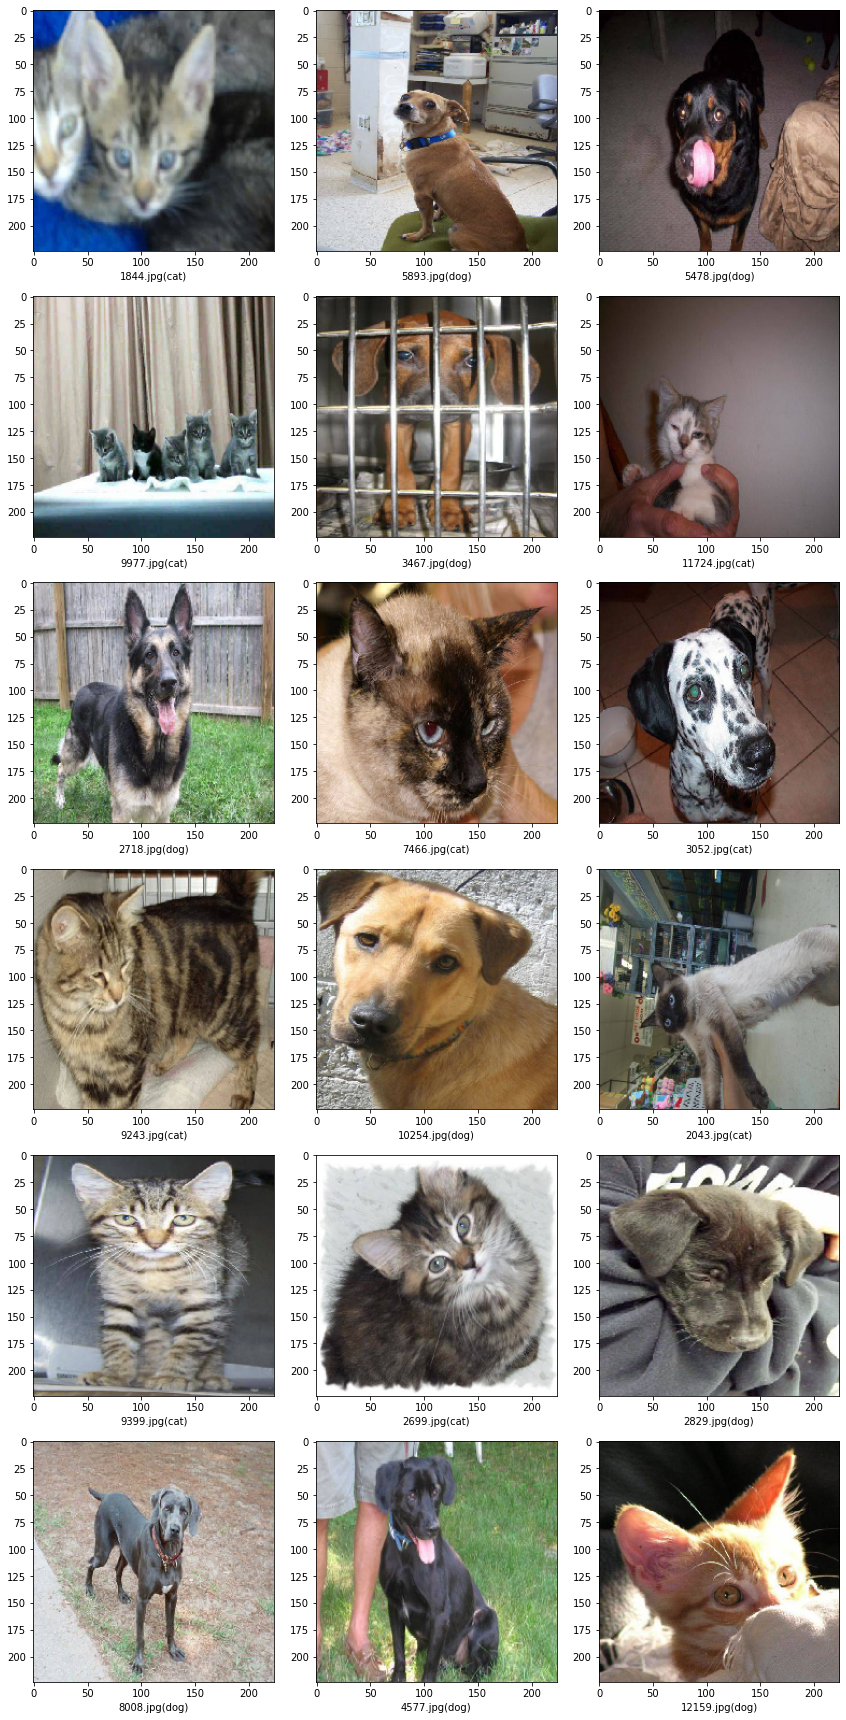

In [79]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=(224,224))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()